GLM like benchmark

already published at https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb

Note difference is that I fit to data of both cities in the same model.

Benchmark fits each city separately.

Also, I don't refit with the complete dataset

In [17]:
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
from src.features.build_features import load_raw

df_all = load_raw()
df_all.keys()

dict_keys(['features_test', 'features_train', 'labels_train', 'submission'])

In [26]:
df_all['features_train'].head(n=2)

year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
city week_start_date                                                   
iq   2000-07-01       2000          26  0.192886  0.132257  0.340886   
     2000-07-08       2000          27  0.216833  0.276100  0.289457   

                       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
city week_start_date                                                          
iq   2000-07-01       0.247200                 25.41             296.740000   
     2000-07-08       0.241657                 60.61             296.634286   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city week_start_date                                                       
iq   2000-07-01                  298.450000                   295.184286   
     2000-07-08                  298.428571                   295.358571   

                            ...          reanalysis_precip_amt_kg_per_m2  \
city week_start_date        ...                                            
iq   2000-07-01             ...                                    43.19   
     2000-07-08             ...                                    46.00   

                      reanalysis_relative_humidity_percent  \
city week_start_date                                         
iq   2000-07-01                                  92.418571   
     2000-07-08                                  93.581429   

                      reanalysis_sat_precip_amt_mm  \
city week_start_date                                 
iq   2000-07-01                              25.41   
     2000-07-08                              60.61   

                      reanalysis_specific_humidity_g_per_kg  \
city week_start_date                                          
iq   2000-07-01                                   16.651429   
     2000-07-08                                   16.862857   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city week_start_date                                          
iq   2000-07-01                8.928571                26.4   
     2000-07-08               10.314286                26.9   

                      station_diur_temp_rng_c  station_max_temp_c  \
city week_start_date                                                
iq   2000-07-01                     10.775000                32.5   
     2000-07-08                     11.566667                34.0   

                      station_min_temp_c  station_precip_mm  
city week_start_date                                         
iq   2000-07-01                     20.7                3.0  
     2000-07-08                     20.8               55.6  

[2 rows x 22 columns]

In [27]:
df_all['labels_train'].head(n=2)

year  weekofyear  total_cases
city week_start_date                               
sj   1990-04-30       1990          18            4
     1990-05-07       1990          19            5

## fillna

In [67]:
for k in ['features_train', 'features_test']:
    df_all[k] = df_all[k].groupby('city').apply(lambda group: group.fillna(method='ffill'))
    assert ~(pd.isnull(df_all[k]).any().any())

## train/test split

In [30]:
# features selected from
# https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb
selected_features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']
assert len(set(selected_features) - set(df_all['features_train'].columns))==0

In [33]:
df_all['features_train'].shape, df_all['labels_train'].shape

((1456, 22), (1456, 3))

In [51]:
# note avoiding class bias
x_train = (df_all['features_train'].reset_index()[['city']+selected_features]
          .groupby('city')
          .apply(lambda group: group.head(n=group.shape[0]*3//4))
          [selected_features]
          .values)
x_test = (df_all['features_train'].reset_index()[['city']+selected_features]
          .groupby('city')
          .apply(lambda group: group.tail(n=group.shape[0]*1//4))
          [selected_features]
          .values)
y_train = (df_all['labels_train'].reset_index()[['city','total_cases']]
          .groupby('city')
          .apply(lambda group: group.head(n=group.shape[0]*3//4))
          ['total_cases']
          .values)
y_test = (df_all['labels_train'].reset_index()[['city','total_cases']]
          .groupby('city')
          .apply(lambda group: group.tail(n=group.shape[0]*1//4))
          ['total_cases']
          .values)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1092, 4), (364, 4), (1092,), (364,))

## fit

In [52]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
mod1 = sm.GLM(exog  = x_train, endog = y_train, family=sm.families.NegativeBinomial()).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1092
Model:                            GLM   Df Residuals:                     1088
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4524.3
Date:                Wed, 30 May 2018   Deviance:                       1619.6
Time:                        11:02:11   Pearson chi2:                 2.79e+03
No. Iterations:                     9   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0175      0.031     -0.557      0.577      -0.079       0.044
x2             0.0076      0.003      2.900      0.004       0.002       0.013
x3            -0.4051      0.039    -10.275      0.000      -0.482      -0.328
x4             0.5507      0.028     19.370      0.000       0.495       0.606
==============================================================================
"""

## predict on test set

In [59]:
from statsmodels.tools import eval_measures
predictions = mod1.predict(x_test).astype(int) # cast to int since we know the label is integer
eval_measures.meanabs(predictions, y_test)

20.041208791208792

## plot

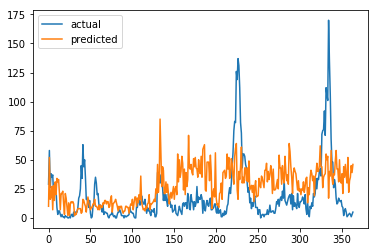

In [60]:
plt.plot(y_test, label='actual')
plt.plot(predictions, label='predicted')
plt.legend()
plt.show()

## set in submission

In [62]:
df_all['submission'].shape

(416, 3)

In [63]:
df_all['submission'].head()

year  weekofyear  total_cases
city week_start_date                               
sj   2008-04-29       2008          18            0
     2008-05-06       2008          19            0
     2008-05-13       2008          20            0
     2008-05-20       2008          21            0
     2008-05-27       2008          22            0

In [68]:
predictions = mod1.predict(df_all['features_test'][selected_features]).astype(int)
predictions.shape

(416,)

In [69]:
predictions

city  week_start_date
iq    2010-07-02         14
      2010-07-09         14
      2010-07-16         18
      2010-07-23          0
      2010-07-30          1
      2010-08-06          5
      2010-08-13          4
      2010-08-20         11
      2010-08-27          6
      2010-09-03          8
      2010-09-10         12
      2010-09-17          8
      2010-09-24          2
      2010-10-01          8
      2010-10-08          4
      2010-10-15          3
      2010-10-22          4
      2010-10-29          6
      2010-11-05          7
      2010-11-12          3
      2010-11-19          8
      2010-11-26          8
      2010-12-03          6
      2010-12-10         15
      2010-12-17          9
      2010-12-24          6
      2011-01-01         23
      2011-01-08         10
      2011-01-15         12
      2011-01-22         10
                         ..
sj    2012-09-30         54
      2012-10-07         38
      2012-10-14         61
      2012-10-21         2

In [72]:
submit = df_all['submission'].copy()
submit['total_cases'] = predictions

In [73]:
submit.shape

(416, 3)

In [74]:
submit

year  weekofyear  total_cases
city week_start_date                               
sj   2008-04-29       2008          18           23
     2008-05-06       2008          19           37
     2008-05-13       2008          20           24
     2008-05-20       2008          21           57
     2008-05-27       2008          22           37
     2008-06-03       2008          23           80
     2008-06-10       2008          24           40
     2008-06-17       2008          25           42
     2008-06-24       2008          26           33
     2008-07-01       2008          27           66
     2008-07-08       2008          28           49
     2008-07-15       2008          29          106
     2008-07-22       2008          30           43
     2008-07-29       2008          31           53
     2008-08-05       2008          32           37
     2008-08-12       2008          33           48
     2008-08-19       2008          34           38
     2008-08-26       2008          35           40
     2008-09-02       2008          36           45
     2008-09-09       2008          37           26
     2008-09-16       2008          38           51
     2008-09-23       2008          39           30
     2008-09-30       2008          40           14
     2008-10-07       2008          41           53
     2008-10-14       2008          42           32
     2008-10-21       2008          43           46
     2008-10-28       2008          44           50
     2008-11-04       2008          45           66
     2008-11-11       2008          46           55
     2008-11-18       2008          47           50
...                    ...         ...          ...
iq   2012-12-02       2012          48           16
     2012-12-09       2012          49           13
     2012-12-16       2012          50            9
     2012-12-23       2012          51           13
     2013-01-01       2013           1           19
     2013-01-08       2013           2           18
     2013-01-15       2013           3           36
     2013-01-22       2013           4           20
     2013-01-29       2013           5           50
     2013-02-05       2013           6           16
     2013-02-12       2013           7           20
     2013-02-19       2013           8           18
     2013-02-26       2013           9           16
     2013-03-05       2013          10           23
     2013-03-12       2013          11           14
     2013-03-19       2013          12           24
     2013-03-26       2013          13           14
     2013-04-02       2013          14           10
     2013-04-09       2013          15           17
     2013-04-16       2013          16           16
     2013-04-23       2013          17           14
     2013-04-30       2013          18            2
     2013-05-07       2013          19           15
     2013-05-14       2013          20            9
     2013-05-21       2013          21           23
     2013-05-28       2013          22           17
     2013-06-04       2013          23           13
     2013-06-11       2013          24           17
     2013-06-18       2013          25           23
     2013-06-25       2013          26           20

[416 rows x 3 columns]

## plot

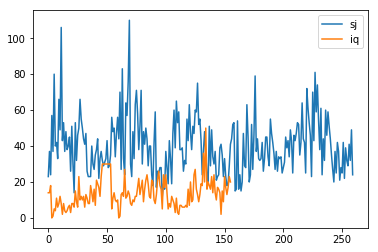

In [77]:
for city in ['sj','iq']:
    plt.plot(submit.loc[city, 'total_cases'].values, label=city)
    
plt.legend()
plt.show()

## Compare to result of notebook 1-...ipynb

In [85]:
df_prev = (pd.read_csv('data/interim/1-submission_20180530_092740-score_29.csv')
             .merge(submit.reset_index(), how='left', on=['city', 'year', 'weekofyear'], suffixes=['_prev', '_curr'])
          ).set_index(['city', 'week_start_date'])
df_prev.head()

year  weekofyear  total_cases_prev  total_cases_curr
city week_start_date                                                      
sj   2008-04-29       2008          18                10                23
     2008-05-06       2008          19                 8                37
     2008-05-13       2008          20                13                24
     2008-05-20       2008          21                10                57
     2008-05-27       2008          22                21                37

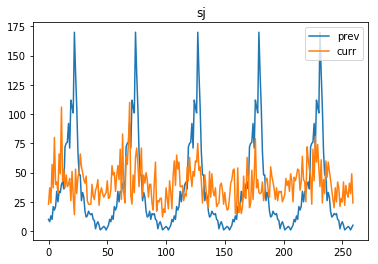

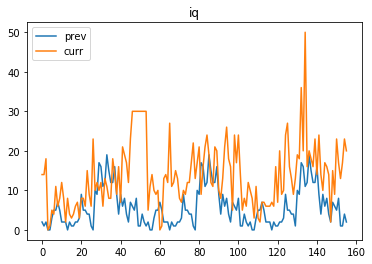

In [87]:
for city in ['sj', 'iq']:
    plt.plot(df_prev.loc[city, 'total_cases_prev'].values, label='prev')
    plt.plot(df_prev.loc[city, 'total_cases_curr'].values, label='curr')
    plt.title(city)
    plt.legend()
    plt.show()

## generate submission file

In [88]:
from src.features.build_features import make_submission

In [90]:
make_submission(submit.reset_index())

('../data/interim/submission_20180530_111647.csv',
 '../data/interim/submission_20180530_111647.csv.zip')